# Preliminary Data Fetch

In [20]:
from neo4j import GraphDatabase
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [21]:
# Neo4j connection details
URI = "bolt://localhost:7687"
AUTH = ("neo4j", "12345678")  # Replace with your actual password

In [22]:
# Verify connection
def verify_connection():
    try:
        with GraphDatabase.driver(URI, auth=AUTH) as driver:
            driver.verify_connectivity()
            print("Connection established.")
    except Exception as e:
        print(f"Failed to connect to Neo4j: {e}")

In [23]:
# Fetch data from Neo4j
def fetchData():
    query = """
    MATCH (e:Employee)-[:CHARGES]->(t:Time)-[:IS_BILLED_FOR]->(p:Project)
    WHERE p.source <> 'Unknown'
    WITH e, p, SUM(t.hours) AS total_time, AVG(e.rate) AS average_rate
    RETURN p.project_type AS project_type, p.source as source, e.employee_name as employee_name, total_time, average_rate, total_time * average_rate AS total_cost
    ORDER BY total_cost DESC
    """
    
    try:
        with GraphDatabase.driver(URI, auth=AUTH) as driver:
            with driver.session() as session:
                result = session.run(query)
                data = [record.data() for record in result]
        
        return pd.DataFrame(data)
    except Exception as e:
        print(f"Failed to fetch data: {e}")
        return pd.DataFrame()

In [24]:
# Verify connection
verify_connection()

# Fetch and display data
data = fetchData()
if data.empty:
    print("No data found. Check your Neo4j database for the required data.")


Connection established.


In [25]:
print(data.head())

       project_type       source      employee_name  total_time  average_rate  \
0  General Services  Sole Source       Melissa Hood     2329.73         600.0   
1  Land Development  Sole Source  Melissa Maldonado     1741.00         585.0   
2  Land Development  Sole Source   Christina Burton     2115.50         420.0   
3    Transportation  Sole Source   Courtney Carlson     2099.25         385.0   
4  General Services  Sole Source   Christina Burton     1735.00         420.0   

   total_cost  
0  1397838.00  
1  1018485.00  
2   888510.00  
3   808211.25  
4   728700.00  


In [26]:
print(data.dtypes)

project_type      object
source            object
employee_name     object
total_time       float64
average_rate     float64
total_cost       float64
dtype: object


# Data Exploration and Analysis

## Revenue Distribution by Project Type
Goal: Identify which project types generate the most revenue.
The outliars are easily identifiable with General Services having an extra high value

C:\Users\lostc\AppData\Local\Temp\ipykernel_32228\2664206370.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\lostc\AppData\Local\Temp\ipykernel_32228\2664206370.py:9: UserWarning: 
The palette list has fewer values (5) than needed (23) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(


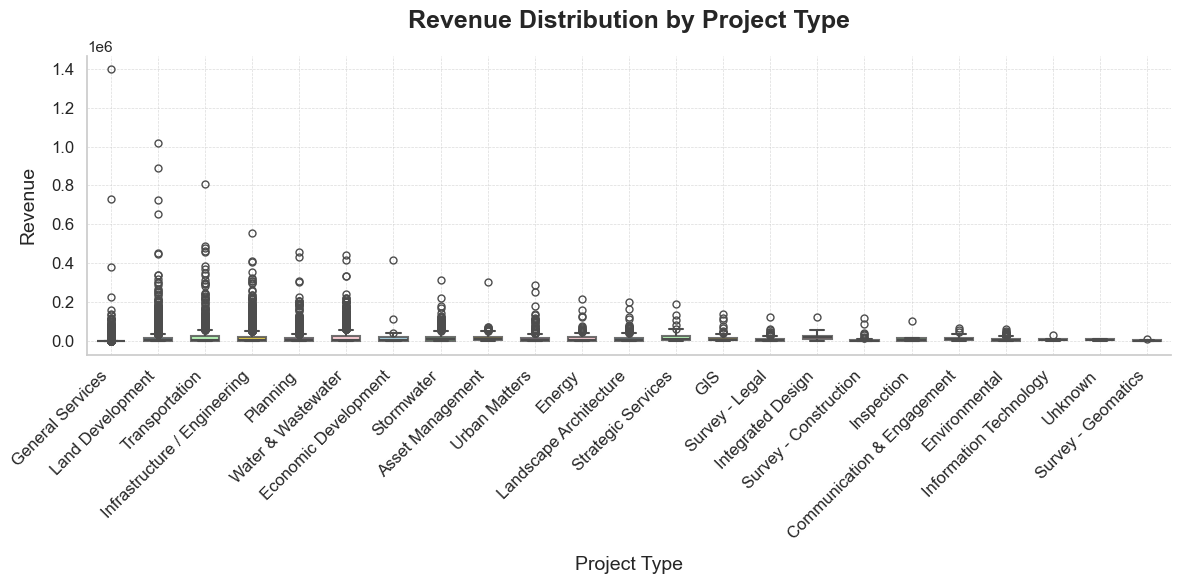

In [27]:
# Set the style for the plot
sns.set(style="whitegrid")

# Create a custom pastel color palette
pastel_palette = ["#FFB6C1", "#87CEEB", "#98FB98", "#FFD700", "#DDA0DD"]

# Revenue distribution by project type
plt.figure(figsize=(12, 6))
sns.boxplot(
    x='project_type', 
    y='total_cost', 
    data=data, 
    palette=pastel_palette,  # Use the custom pastel palette
    width=0.6, 
    linewidth=1.5, 
    fliersize=5,
    boxprops=dict(alpha=0.8)  # Add transparency to the boxes
)

# Enhance the plot aesthetics
plt.title('Revenue Distribution by Project Type', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Project Type', fontsize=14, labelpad=10)
plt.ylabel('Revenue', fontsize=14, labelpad=10)
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.yticks(fontsize=12)

# Add grid lines for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Remove the top and right spines for a cleaner look
sns.despine()

# Show the plot
plt.tight_layout()
plt.show()

## Average Revenue by Project Type
Goal: Another perspective to identify which project types generate the most revenue

C:\Users\lostc\AppData\Local\Temp\ipykernel_32228\869782840.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


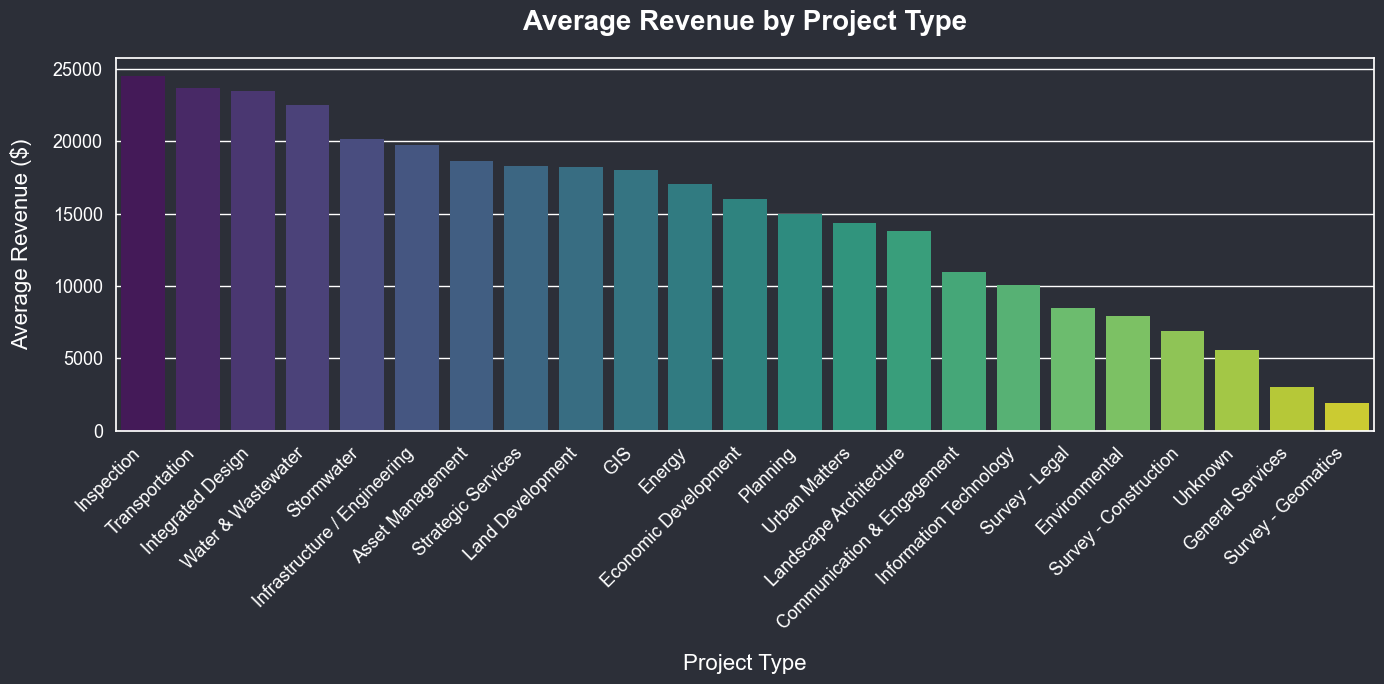

In [28]:
# Calculate average revenue by project type
avg_revenue_by_type = data.groupby('project_type')['total_cost'].mean().reset_index()

# Sort by 'total_cost' in descending order
avg_revenue_by_type = avg_revenue_by_type.sort_values(by='total_cost', ascending=False)

# Set the dark background theme with the 'inferno' palette
sns.set_theme(style="darkgrid", palette="inferno")

# Plot average revenue by project type
plt.figure(figsize=(14, 7))
sns.barplot(
    x='project_type', 
    y='total_cost', 
    data=avg_revenue_by_type, 
    palette="viridis",  # Use the 'inferno' palette for a dark mode look
    edgecolor='none'  # Remove the white outline on bars
)

# Enhance the plot aesthetics for dark mode
plt.title('Average Revenue by Project Type', fontsize=20, fontweight='bold', color='white', pad=20)
plt.xlabel('Project Type', fontsize=16, labelpad=15, color='white')
plt.ylabel('Average Revenue ($)', fontsize=16, labelpad=15, color='white')

# Adjust x-axis labels to prevent overlapping
plt.xticks(rotation=45, fontsize=13, ha='right', color='white')  # Rotate labels and change font color
plt.yticks(fontsize=13, color='white')  # Change y-tick font color to white

# Make background color and gridlines match
plt.gca().set_facecolor('#2c2f38')  # Set axes (plot area) background to dark grey
plt.gcf().set_facecolor('#2c2f38')  # Set figure background to dark grey

# Adjust the layout for dark mode
plt.tight_layout()

# Show the plot
plt.show()


## Average Time by Project Type
Goal: Identify which projects are more time consuming

C:\Users\lostc\AppData\Local\Temp\ipykernel_32228\2063444556.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='total_time', y='project_type', data=avg_time_by_type, palette="inferno_r", edgecolor='none')


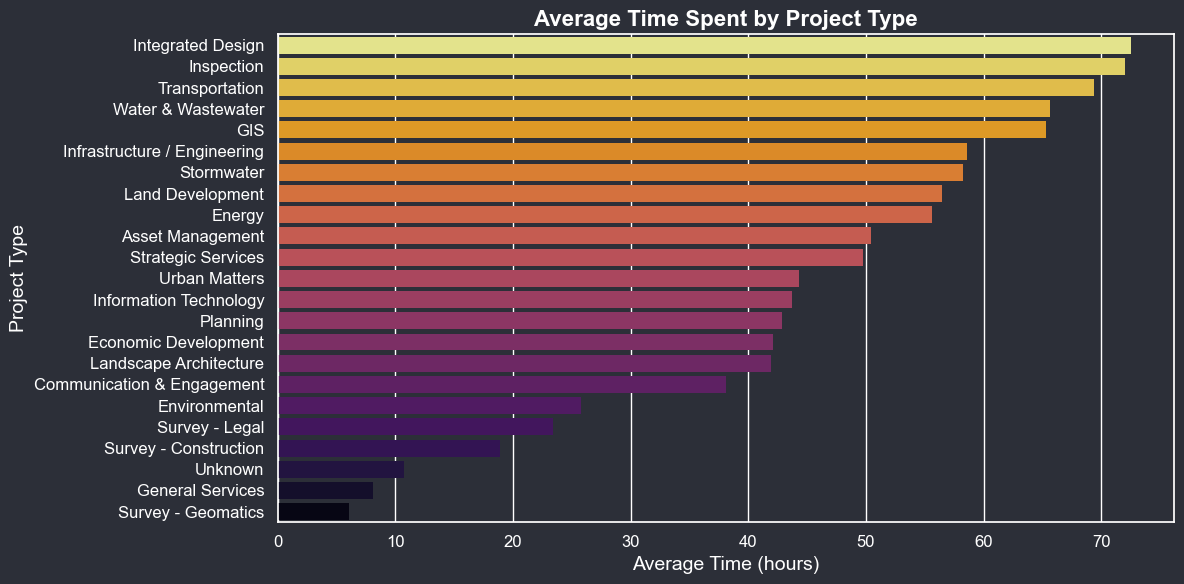

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate average time by project type
avg_time_by_type = data.groupby('project_type')['total_time'].mean().reset_index()

# Sort by 'total_time' in descending order
avg_time_by_type = avg_time_by_type.sort_values(by='total_time', ascending=False)

# Set the dark theme with the 'inferno' palette
sns.set_theme(style="darkgrid", palette="inferno")  # Use inferno palette

# Create the horizontal bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='total_time', y='project_type', data=avg_time_by_type, palette="inferno_r", edgecolor='none')

# Set the title and labels with white text for contrast
plt.title('Average Time Spent by Project Type', fontsize=16, fontweight='bold', color='white')
plt.xlabel('Average Time (hours)', fontsize=14, color='white')
plt.ylabel('Project Type', fontsize=14, color='white')

# Adjust ticks to have white text
plt.xticks(fontsize=12, color='white')
plt.yticks(fontsize=12, color='white')

# Adjust figure background color to dark
plt.gcf().set_facecolor('#2c2f38')  # Dark background for the figure
plt.gca().set_facecolor('#2c2f38')  # Dark background for the axes

# Show the plot
plt.tight_layout()
plt.show()


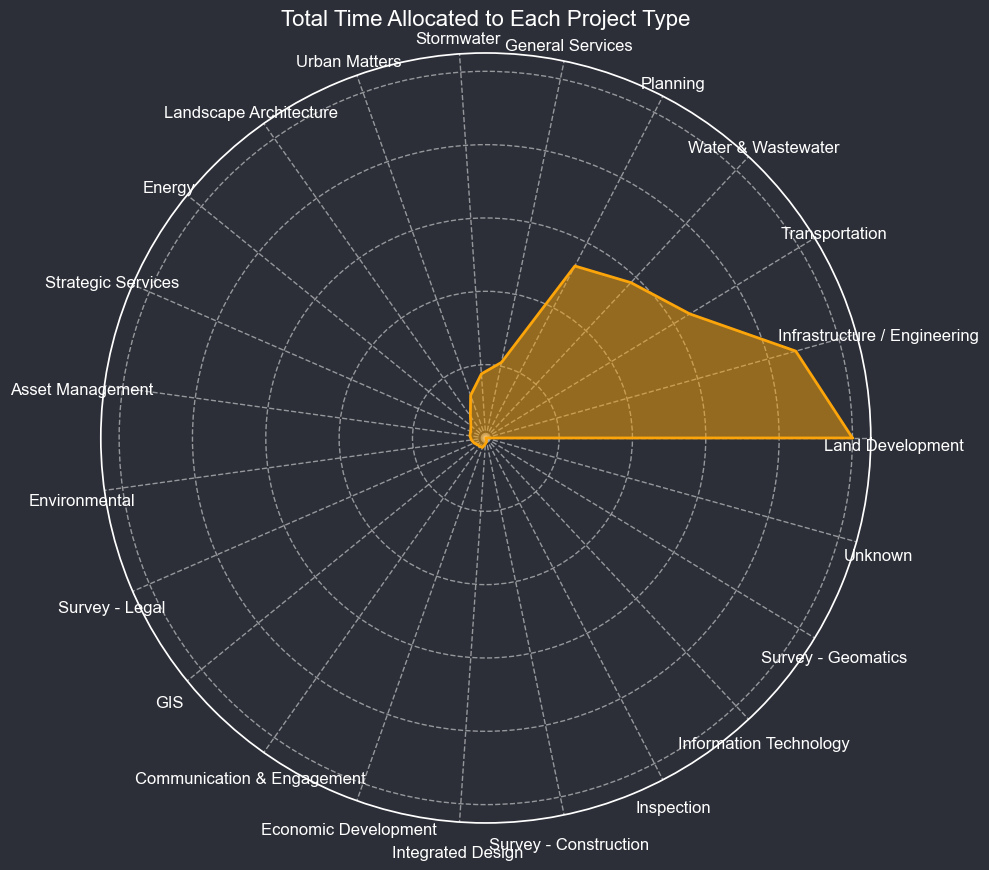

In [30]:
# Step 1: Calculate the total time for each project type
avg_time_by_type = data.groupby('project_type')['total_time'].sum().reset_index()

# Step 2: Sort by total time in descending order
avg_time_by_type = avg_time_by_type.sort_values(by='total_time', ascending=False)

# Step 3: Normalize the total time (optional)
max_time = avg_time_by_type['total_time'].max()
avg_time_by_type['normalized_time'] = avg_time_by_type['total_time'] / max_time

# Set up the radar plot
categories = avg_time_by_type['project_type'].tolist()
values = avg_time_by_type['normalized_time'].tolist()

# Number of categories
num_vars = len(categories)

# Compute the angle for each category
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Make the plot circular by appending the first value to the end
values += values[:1]
angles += angles[:1]

# Create the radar plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))  # Increased figure size

# Set the background color of the figure and the axes to the same color
fig.patch.set_facecolor('#2c2f38')  # Dark color for the figure
ax.set_facecolor('#2c2f38')  # Dark color for the radar axes

# Use inferno color map for the plot's lines and fill
cmap = plt.cm.inferno
color = cmap(0.8)  # Pick a color from the inferno palette

# Plot the data
ax.fill(angles, values, color=color, alpha=0.5)
ax.plot(angles, values, color=color, linewidth=2)

# Set the categories (labels)
ax.set_yticklabels([])  # Hide radial ticks
ax.set_xticks(angles[:-1])

# Spread the labels by adjusting the font size and using rotation
ax.set_xticklabels(categories, fontsize=12, color='white', horizontalalignment='center', verticalalignment='top')

# Set the title
ax.set_title('Total Time Allocated to Each Project Type', fontsize=16, color='white', pad=20)

# Adjust the grid and other properties
plt.grid(color='white', linestyle='--', alpha=0.5)  # Grid with dashed lines
ax.tick_params(axis='x', color='white')  # Change color of x-axis ticks
ax.tick_params(axis='y', color='white')  # Change color of y-axis ticks

# Show the plot
plt.tight_layout()
plt.show()


## Total Time Spent vs Revenue Generated
Goal: Determine whether the time spent is worth the 
Identify any special types of projects with high cost

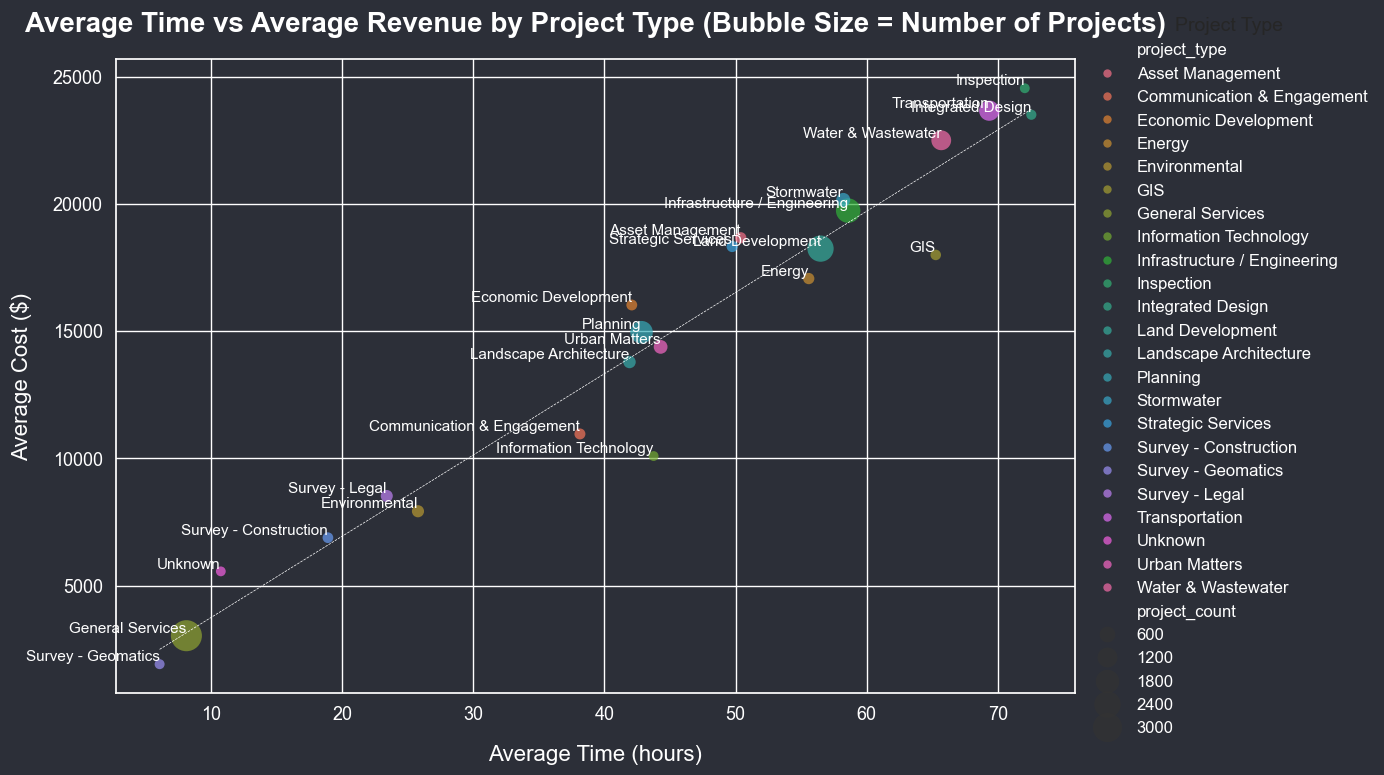

In [31]:
# Set the font to a different one (e.g., "Arial" or "Verdana")
plt.rcParams["font.family"] = "Arial"  # Change to any font you prefer

# Calculate the average time, average cost, and count of projects per project type
avg_time_cost = data.groupby('project_type')[['total_time', 'total_cost']].mean().reset_index()
project_count = data.groupby('project_type').size().reset_index(name='project_count')

# Merge the project count with the avg_time_cost DataFrame
avg_time_cost = avg_time_cost.merge(project_count, on='project_type')

# Set the dark background theme
sns.set_theme(style="darkgrid", palette="magma")

# Plot average time vs average cost by project type
plt.figure(figsize=(14, 8))
scatter_plot = sns.scatterplot(
    x='total_time',  # Average time
    y='total_cost',  # Average cost
    data=avg_time_cost, 
    hue='project_type',  # Color by project type (each project type gets a unique color)
    palette='husl',  # Use the 'husl' palette for distinct colors
    size='project_count',  # Bubble size based on number of projects
    sizes=(50, 500),  # Adjust size range of bubbles (min and max size)
    edgecolor='none',  # Remove the outline around bubbles
    alpha=0.7  # Adjust transparency for better visibility
)

# Annotate the points with labels (top-left of each point)
for i in range(len(avg_time_cost)):
    scatter_plot.text(
        avg_time_cost['total_time'][i],  # X-coordinate
        avg_time_cost['total_cost'][i],  # Y-coordinate
        avg_time_cost['project_type'][i],  # Project type as label
        horizontalalignment='right',  # Align the label to the left
        fontsize=11, 
        color='white',  # White text to stand out against dark background
        weight='normal',  # Make the text normal weight
        verticalalignment='bottom',  # Align the label to the top of the point
    )

# Add the linear regression line without the confidence interval shading
sns.regplot(
    x='total_time', 
    y='total_cost', 
    data=avg_time_cost, 
    scatter=False,  # Don't plot scatter points again
    color='white',  # Line color
    line_kws={'linestyle': '--', 'linewidth': 0.5},  # Line style and thickness
    ci=None  # Removes the confidence interval shading around the line
)

# Add labels and title
plt.title('Average Time vs Average Revenue by Project Type (Bubble Size = Number of Projects)', 
          fontsize=20, fontweight='bold', color='white', pad=20)
plt.xlabel('Average Time (hours)', fontsize=16, labelpad=15, color='white')
plt.ylabel('Average Cost ($)', fontsize=16, labelpad=15, color='white')

# Adjust x and y-axis ticks
plt.xticks(fontsize=13, color='white')
plt.yticks(fontsize=13, color='white')

# Adjust layout for dark mode aesthetics
plt.gca().set_facecolor('#2c2f38')  # Set axes background to dark grey
plt.gcf().set_facecolor('#2c2f38')  # Set figure background to dark grey

# Move the legend outside the plot to the right and change legend text color to white
plt.legend(title='Project Type', title_fontsize=14, fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5), 
           frameon=False, labelcolor='white')

# Show the plot
plt.tight_layout()
plt.show()


# Model Training

## Data Pre-processing

In [32]:
# One-hot encode all categorical variables
categorical_columns = ['project_type', 'source', 'employee_name']  # All categorical columns
encoded_df = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# Define features (X) and target (y)
X = encoded_df.drop('total_cost', axis=1)  # Features: all columns except 'total_cost'
y = encoded_df['total_cost']  # Target: 'total_cost'

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verify shapes
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (11332, 773)
Testing data shape: (2833, 773)


In [33]:
# Hyperparameter Tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

# Initialize the Random Forest Regressor
rfr = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=rfr,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Use MSE for regression
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all available CPU cores
    verbose=2  # Print progress
)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Evaluate the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Best Model MSE: {mse}")
print(f"Best Model R²: {r2}")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


c:\Users\lostc\OneDrive\Desktop\company-ML\venv\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
540 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\lostc\OneDrive\Desktop\company-ML\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\lostc\OneDrive\Desktop\company-ML\venv\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "c:\Users\lostc\OneDrive\Desktop\company-ML\venv\lib\site-packages\sklearn\base.py", line 436, in _validat

Best Hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best Model MSE: 108813662.17185104
Best Model R²: 0.9159579644981242


In [34]:
# Compare models

# Default model
default_model = RandomForestRegressor(random_state=42)
default_model.fit(X_train, y_train)
y_pred_default = default_model.predict(X_test)
mse_default = mean_squared_error(y_test, y_pred_default)
r2_default = r2_score(y_test, y_pred_default)

# Tuned model
y_pred_tuned = best_model.predict(X_test)
mse_tuned = mean_squared_error(y_test, y_pred_tuned)
r2_tuned = r2_score(y_test, y_pred_tuned)

print("Default Model MSE:", mse_default)
print("Tuned Model MSE:", mse_tuned)
print("Default Model R²:", r2_default)
print("Tuned Model R²:", r2_tuned)

Default Model MSE: 12885034.781139854
Tuned Model MSE: 108813662.17185104
Default Model R²: 0.9900482666523139
Tuned Model R²: 0.9159579644981242


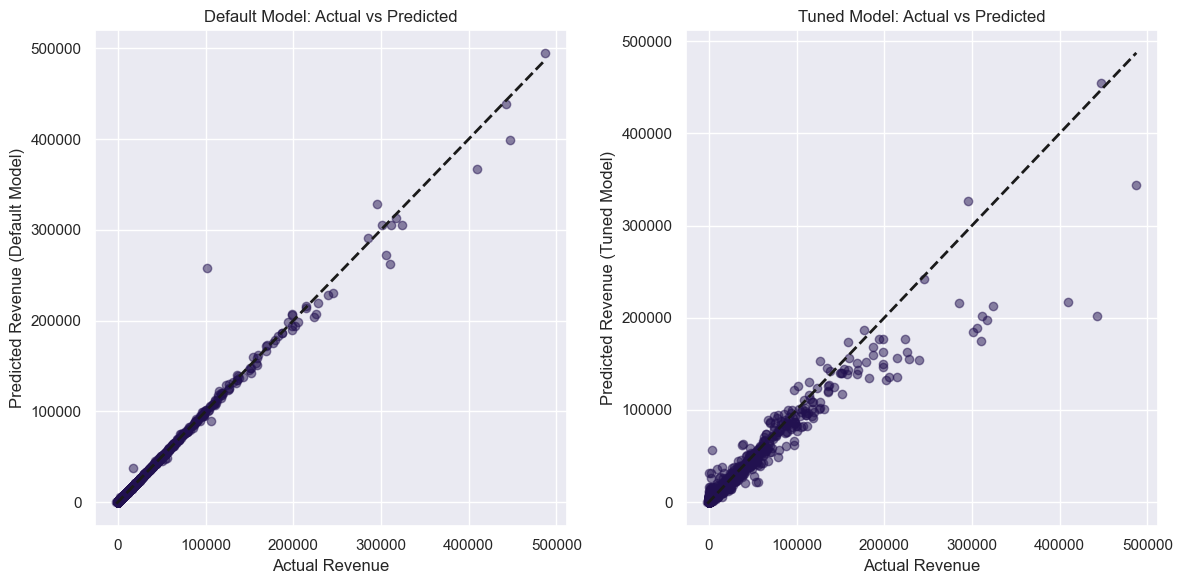

In [35]:
# Visualize comparison

# Plot actual vs predicted for default and tuned models
plt.figure(figsize=(12, 6))

# Default model
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_default, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Revenue')
plt.ylabel('Predicted Revenue (Default Model)')
plt.title('Default Model: Actual vs Predicted')

# Tuned model
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_tuned, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Revenue')
plt.ylabel('Predicted Revenue (Tuned Model)')
plt.title('Tuned Model: Actual vs Predicted')

plt.tight_layout()
plt.show()

## Training the Model

In [36]:
# Train Random Forest Regressor
model = RandomForestRegressor(n_estimators=50, max_depth=None, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', n_estimators=50, random_state=42)

In [37]:
# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred) # Using mean squared due to regression problem
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2: .2f}")
print(f"Mean Absolute Error: {mae:.2f}")

Mean Squared Error: 108813662.17
R-squared:  0.92
Mean Absolute Error: 2603.85


In [39]:
#Predict on the training data to see if we are overfitting
y_train_pred = model.predict(X_train)

# Calculate training metrics
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)

print("Training MSE:", mse_train)
print("Training R²:", r2_train)
print("Training MAE:", mae_train)

Training MSE: 44569880.123803094
Training R²: 0.9725616492889273
Training MAE: 1107.2648369219908


# Visualize Results

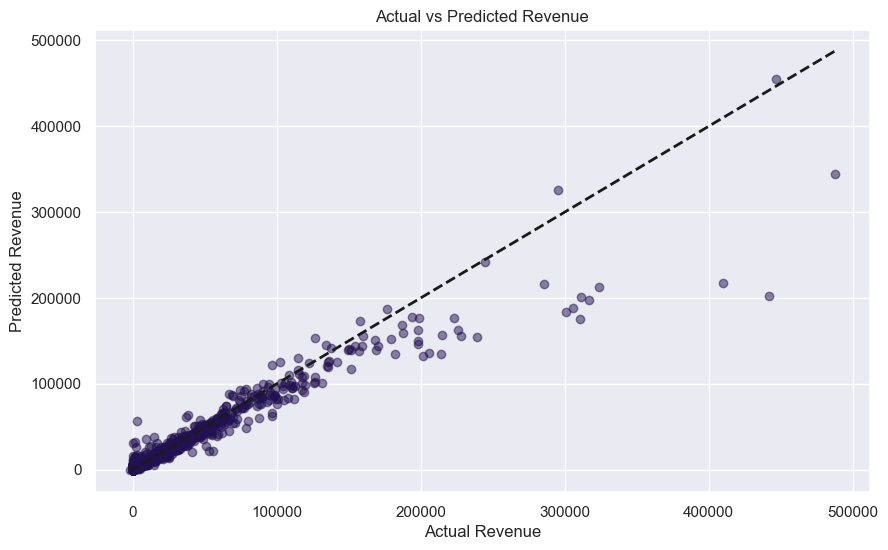

In [40]:
# Compare predicted Actual vs Predicted Revenue
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5) # Scatter Plot
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) # Line of perfect predictions
plt.xlabel('Actual Revenue')
plt.ylabel('Predicted Revenue')
plt.title('Actual vs Predicted Revenue')
plt.show()